# PetFinder.my - Pawpularity Contest
Date : 2021/09/23 ~ 2022/01/22

Start date : 2021/10/01 

Data : ID를 포함한 13개의 컬럼, 사진 메타데이터, 사진데이터

Metric : RMSE(평균제곱근오차)

Questions Type : 예측(Prediction)

# Exploring

1. 사진을 제외한 데이터들을 이용하여 예측.
2. 사진과 데이터들을 같이 포함하여 예측.
3. 사진만 이용하여 예측

1 :변수끼리의 관계를 중점적으로 확인

2 : 사진안에 어떠한 부분이 Pawpularity 점수에 

유의미한 영향을 끼치는지 확인(LIME)

-> 2DCNN 등등 

핵심 : 사진과 Binary 데이터들을 어떤식으로 조합하여 예측에 사용할지

# Exploratory Data Analysis

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [5]:

test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [6]:
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [7]:
train_df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


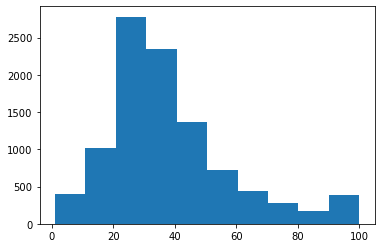

In [9]:
plt.hist(train_df['Pawpularity'])
plt.show()

# Pawpularity 점수를 구간별로 나눈뒤 해당 구간에 Binary 데이터들이
# 어떤식으로 분포되어있는지 안다면 예측에 좀더 용이하지 않을까?
# A -> 낮은점수와 높은점수간 데이터의 분포가 다르지 않음


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Pawpularity', ylabel='Density'>

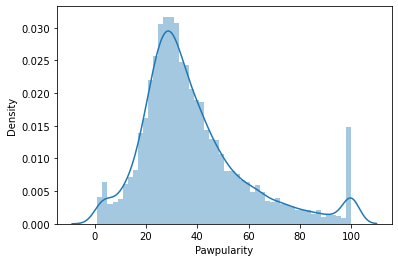

In [10]:
sns.distplot(train_df['Pawpularity'])
# Pawpularity변수는 정규분포로 보임

높은 점수와 낮은 점수의 차이를 살펴보기 위해  
Pawpularty 점수를 0-49(낮음) 50~100(높음)으로 나누어

각 구간에 따른 데이터셋의 분포를 살펴보자


In [11]:
low_paw = train_df.loc[train_df.Pawpularity<50].iloc[:,1:].sample(1000)
high_paw = train_df.loc[(train_df.Pawpularity>=50) & (train_df.Pawpularity <=100)].iloc[:,1:].sample(1000)

<AxesSubplot:>

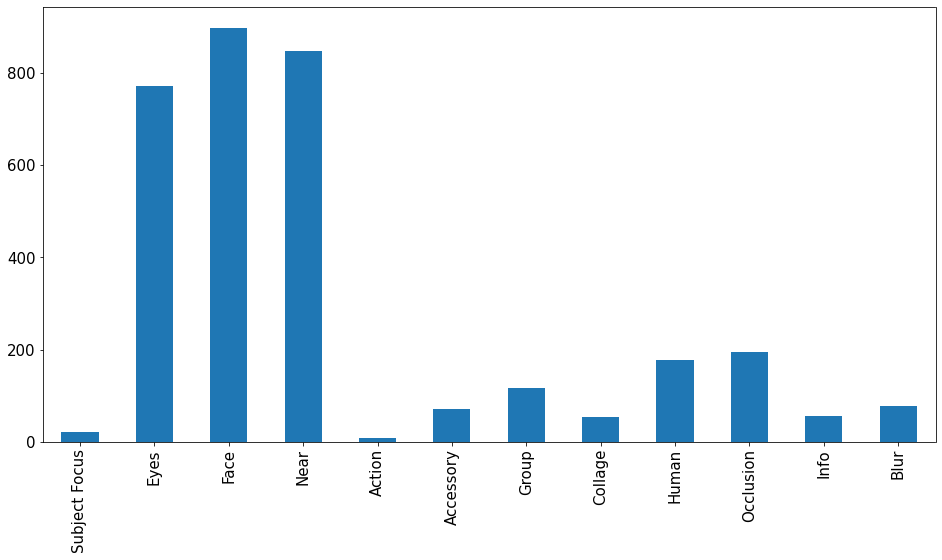

In [12]:
low_paw.iloc[:,:-1].sum().plot.bar(figsize=(16,8),fontsize=15)

<AxesSubplot:>

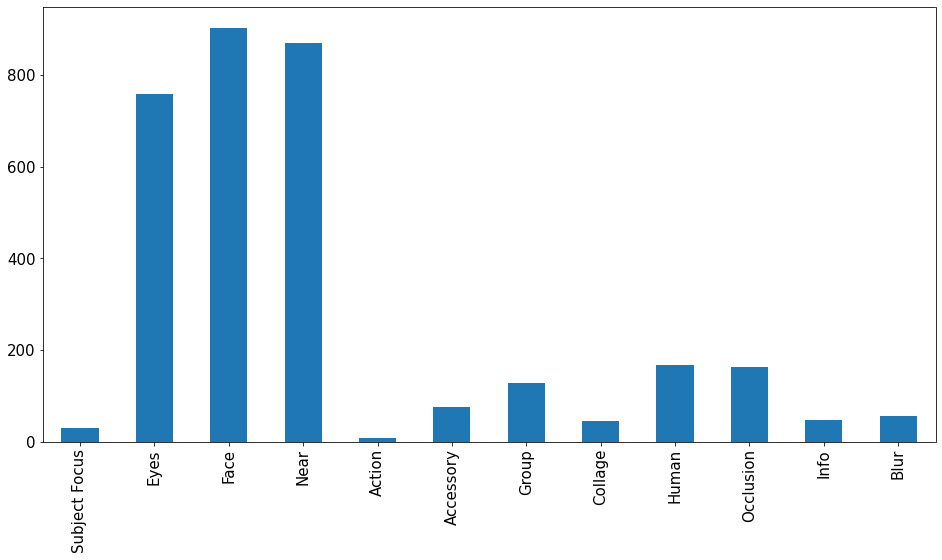

In [13]:
high_paw.iloc[:,:-1].sum().plot.bar(figsize=(16,8),fontsize=15)

현재로써는 Pawpularity 점수와 데이터셋에는 영향이 많이 없어보임

독립변수와 종속변수의 상관관계를 확인

 이산형 -> 연속형이므로 점이연 상관관계(Point biserial correlation)



In [14]:
#pvalue가  .05보다 작을경우 통계적으로 유의, 클경우 유의하지 않음
stats.pointbiserialr(low_paw.iloc[:,1],low_paw.iloc[:,-1])

PointbiserialrResult(correlation=0.05718473222557974, pvalue=0.07067539132899162)

In [16]:
temp = train_df.iloc[:,1:]

In [61]:
corr_list=[]
p_value =[]
for columns in temp.iloc[:,:-1]:
    x = temp[columns]
    corr = stats.pointbiserialr(list(x),list(temp['Pawpularity']))
    if corr[1] < 0.05:
        p_value.append('유의')
    else : 
        p_value.append('유의하지 않음')
    corr_list.append(corr[0])
    
point_corr = pd.DataFrame({'Pawpularity' : corr_list, 'P_value' : p_value}).set_index(temp.iloc[:,:-1].columns)
point_corr.sort_values(by=['Pawpularity'],axis=0,ascending=False)

,Pawpularity,P_value
Group,0.016469,유의하지 않음
Accessory,0.013287,유의하지 않음
Face,0.008018,유의하지 않음
Human,0.003983,유의하지 않음
Occlusion,0.001979,유의하지 않음
Collage,0.001732,유의하지 않음
Near,0.001001,유의하지 않음
Action,-0.001373,유의하지 않음
Info,-0.004735,유의하지 않음
Eyes,-0.006686,유의하지 않음


통계적으로도 유의하지 않으며, 이렇다할 상관관계도 보이지 않음

높은점수와 낮은점수에서의 상관관계는?

In [62]:
corr_list=[]
p_value =[]
for columns in high_paw.iloc[:,:-1]:
    x = high_paw[columns]
    corr = stats.pointbiserialr(list(x),list(high_paw['Pawpularity']))
    if corr[1] < 0.05:
        p_value.append('유의')
    else : 
        p_value.append('유의하지 않음')
    corr_list.append(corr[0])
    
point_corr = pd.DataFrame({'Pawpularity' : corr_list, 'P_value' : p_value}).set_index(high_paw.iloc[:,:-1].columns)
point_corr.sort_values(by=['Pawpularity'],axis=0,ascending=False)

,Pawpularity,P_value
Near,0.040242,유의하지 않음
Action,0.031567,유의하지 않음
Collage,0.027960,유의하지 않음
Accessory,0.017104,유의하지 않음
Blur,0.014990,유의하지 않음
Human,0.008588,유의하지 않음
Occlusion,-0.010947,유의하지 않음
Info,-0.017008,유의하지 않음
Subject Focus,-0.018194,유의하지 않음
Group,-0.018312,유의하지 않음


In [63]:
corr_list=[]
p_value =[]
for columns in low_paw.iloc[:,:-1]:
    x = low_paw[columns]
    corr = stats.pointbiserialr(list(x),list(low_paw['Pawpularity']))
    if corr[1] < 0.05:
        p_value.append('유의')
    else : 
        p_value.append('유의하지 않음')
    corr_list.append(corr[0])
    
point_corr = pd.DataFrame({'Pawpularity' : corr_list, 'P_value' : p_value}).set_index(low_paw.iloc[:,:-1].columns)
point_corr.sort_values(by=['Pawpularity'],axis=0,ascending=False)

,Pawpularity,P_value
Occlusion,0.087368,유의
Eyes,0.057185,유의하지 않음
Collage,0.042457,유의하지 않음
Human,0.037124,유의하지 않음
Info,0.024326,유의하지 않음
Face,0.012777,유의하지 않음
Group,0.011981,유의하지 않음
Accessory,0.000504,유의하지 않음
Action,-0.000456,유의하지 않음
Blur,-0.007367,유의하지 않음


역시나 이렇다할 상관관계는 보이지 않는다

컬럼만으로 정확한 점수를 예측하는것에는 무리가 있어보이나

일단 예측을 시도해보자

In [75]:
x,y = temp.iloc[:,:-1], temp.Pawpularity
dmatrix = xgb.DMatrix(data = x, label = y)

X_train,X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=411)

xgr = xgb.XGBRegressor()

params = {
         'learning_rate' : [.03,0.05,.07],
         'max_depth': [5,6,7],
         'min_child_weight' :[4],
         'subsample' : [1],
         'colsample_bytree' : [1],
         'eval_metric' : ['rmse']}
grid = GridSearchCV(xgr,param_grid = params, cv=3,scoring='neg_root_mean_squared_error')
grid.fit(X_train,y_train)

print('best param : ', grid.best_params_)
print('best score : ', grid.best_score_)
estimator = grid.best_estimator_
predict = estimator.predict(X_test)


best param :  {'colsample_bytree': 1, 'eval_metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 1}
best score :  -20.572131172424232


In [43]:
estimator.predict(test_df.iloc[:,1:])

array([39.0342  , 37.564137, 63.37477 , 33.7519  , 17.69668 , 57.854275,
       25.512817, 38.474003], dtype=float32)

In [45]:
sub_df = pd.DataFrame()
sub_df['Id'] = test_df['Id']
sub_df['Petpularity'] = estimator.predict(test_df.iloc[:,1:])
sub_df.head()
sub_df.to_csv('./sub_mission/1.csv')

In [48]:
estimator.predict(test_df.iloc[:,1:])

array([39.0342  , 37.564137, 63.37477 , 33.7519  , 17.69668 , 57.854275,
       25.512817, 38.474003], dtype=float32)

In [49]:
sub_df

,Id,Petpularity
0,4128bae22183829d2b5fea10effdb0c3,39.034199
1,43a2262d7738e3d420d453815151079e,37.564137
2,4e429cead1848a298432a0acad014c9d,63.374771
3,80bc3ccafcc51b66303c2c263aa38486,33.751900
4,8f49844c382931444e68dffbe20228f4,17.696680
5,b03f7041962238a7c9d6537e22f9b017,57.854275
6,c978013571258ed6d4637f6e8cc9d6a3,25.512817
7,e0de453c1bffc20c22b072b34b54e50f,38.474003


In [60]:
mean_squared_error(y_test,predict)**0.5

20.953842886463967

In [73]:
x,y = temp.iloc[:,:-1], temp.Pawpularity

X_train,X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=411)

gbm = lgb.LGBMRegressor()

params ={'learning_rate' : [.03,0.05,.07],
        'num_iterations' : [1000],
        'max_depth' : [5,6,7],
        'colsample_bytree' : [0.7],
        'boosting_type' : ['dart'],
        'metric' : ['regression_l2'],
        'min_child_weight' :[4],
        'metric' : ['rmse']}
grid = GridSearchCV(gbm,param_grid = params, cv=3,scoring='neg_root_mean_squared_error')
grid.fit(X_train,y_train)

print('best param : ', grid.best_params_)
print('best score : ', grid.best_score_)
estimator = grid.best_estimator_
predict = estimator.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserW

best param :  {'boosting_type': 'dart', 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'metric': 'rmse', 'min_child_weight': 4, 'num_iterations': 1000}
best score :  -20.57207448531338


In [74]:
mean_squared_error(y_test,predict)**0.5

20.947771891350307

컬럼데이터만으로 예측하기에는 무리가 있음 2021-10-04 기준 415등

사진데이터 + 컬럼데이터 예측을 해보자